In [ ]:
!pip install bm3d

# TP1 : Imagerie Computationnelle 

## Débruitage

### 1. Considérons une image en niveaux de gris de votre choix, notée i (par exemple Lena 512x512 pixels), avec une  puissance  Pi.  Notre  objectif  est  de  dégrader  cette  image  en  ajoutant  un  bruit  gaussien  additif, indépendant de l'image, dont la puissance est fixée pour obtenir un rapport signal sur bruit (signal noise ratio (SNR) en anglais) de 15 dB. L'image résultante sera désignée par ib.  

<img src="lena.png" width="200">

#### a. Exprimez la formule de la puissance de ce bruit en fonction de Pi et du SNR. 

Sachant : \
SNR = 10 * log10(Pi / Pb) \
Pi = 1/N * sum(k=1 to N) (img[k]^2)

In [3]:
import numpy as np

def calculer_SNR(Pi, Pb):
    SNR = 10 * np.log10(Pi / Pb)
    return SNR

def calculer_Pi(Pb, SNR):
    Pi = Pb * (10 ** (SNR / 10))
    return Pi

def calculer_puissance_bruit(Pi, SNR):
    Pb = Pi / (10 ** (SNR / 10))
    return Pb

#### b. Écrivez une fonction en Matlab/Python capable de générer l'image bruitée ib, prenant comme entrées l’image i et le SNR, et comme sortie l'image ib.

In [4]:
import matplotlib.pyplot as plt

def ajouter_bruit_gaussien(image, SNR):
    Pi = np.mean(image ** 2)
    Pb = calculer_puissance_bruit(Pi, SNR)
    bruit = np.random.randn(*image.shape) * np.sqrt(Pb)
    image_bruitee = image + bruit
    return image_bruitee

#### c. Affichez les images i et ib.

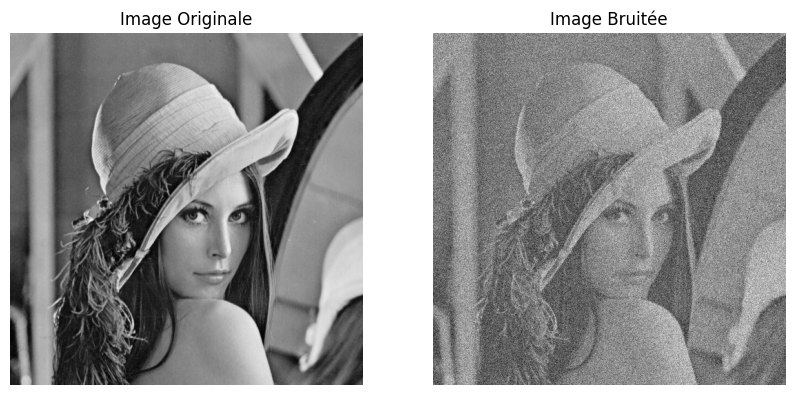

In [5]:

image = plt.imread("lena.png")
SNR = 10

image_bruitee = ajouter_bruit_gaussien(image, SNR)

plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.title("Image Originale")
plt.imshow(image, cmap='gray')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title("Image Bruitée")
plt.imshow(image_bruitee, cmap='gray')
plt.axis('off')

plt.show()

#### d. Faites varier la variable SNR de 0 dB à 50 dB. Commentez les résultats obtenus. 

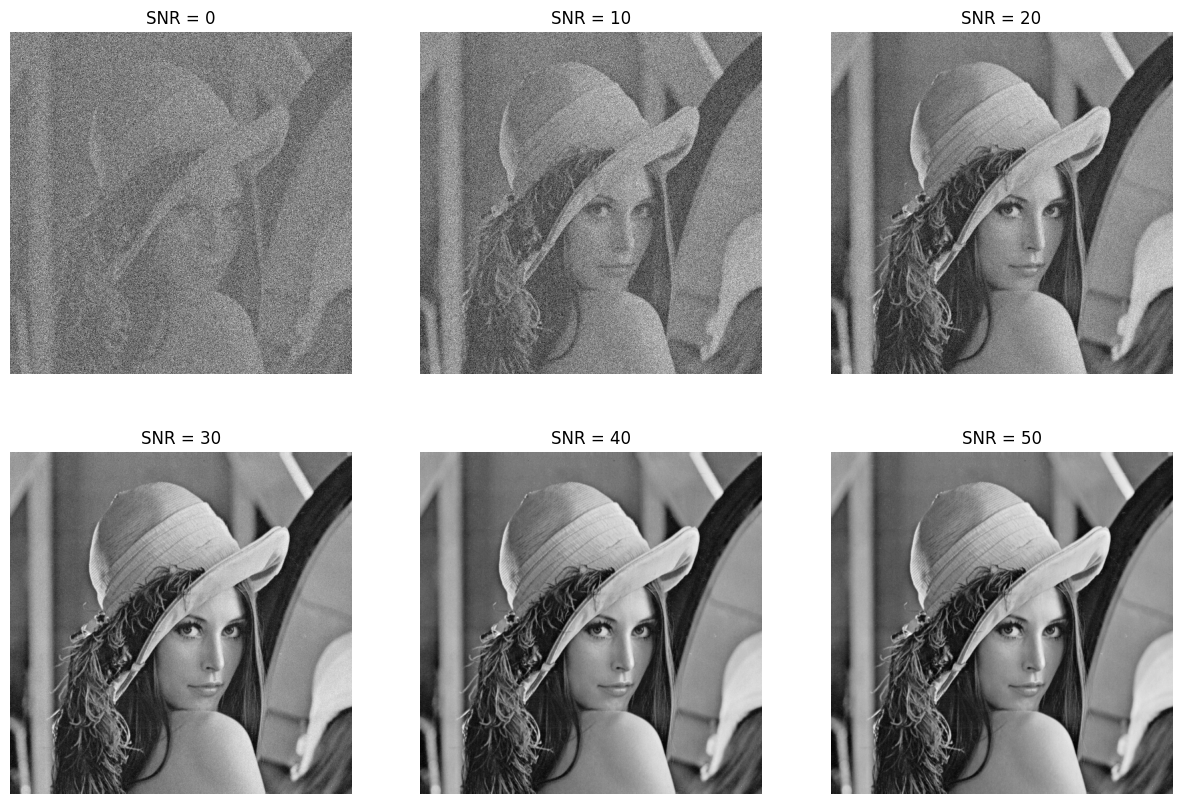

In [6]:
images_bruitees = []
number_of_images = 6

for SNR in range(number_of_images):
    SNR = SNR * 10
    image_bruitee = ajouter_bruit_gaussien(image, SNR)
    images_bruitees.append(image_bruitee)

plt.figure(figsize=(15, 10))

for i, image_bruitee in enumerate(images_bruitees):
    plt.subplot(2, 3, i + 1)
    plt.title(f"SNR = {i * 10}")
    plt.imshow(image_bruitee, cmap='gray')
    plt.axis('off')
    
plt.show()

***Nous pouvons voir que plus le SNR est élevé, moins le bruit est présent dans l'image, et plus les détails de l'image originale sont préservés et au contraire, plus le SNR est faible, plus le bruit est présent dans l'image et plus les détails de l'image originale sont perdus.***

### 2. Nous examinons maintenant une image bruitée ib affectée par un bruit gaussien de 20 dB. L'objectif des questions suivantes est de débruiter cette image en utilisant différentes méthodes abordées en cours. Pour chaque  méthode  mise  en  œuvre,  outre  l'évaluation  visuelle,  deux  critères  quantitatifs  seront  pris  en compte : l'erreur quadratique moyenne et le PSNR (Peak Signal-to-Noise Ratio) entre l'image estimée et l'image i. Pour chaque méthode, nous tenterons de fixer les hyperparamètres respectifs à leur meilleure valeur.  
a. Filtrage linéaire Gaussien 2D. \
b. Filtrage bilatéral. \
c. Filtrage moyen non local. \
d. BM3D.

In [7]:
import itertools
import cv2
import numpy as np
from skimage.metrics import peak_signal_noise_ratio as psnr, mean_squared_error as mse
import bm3d
import matplotlib.pyplot as plt

image = plt.imread("lena.png")
SNR = 20
image_bruitee = ajouter_bruit_gaussien(image, SNR)

image_bruitee = image_bruitee.astype(np.float32)

def image_to_8bit(image):
    return np.round(np.clip((image * 255), 0, 255)).astype(np.uint8)

image_8bit = image_to_8bit(image)
image_bruitee_8bit = image_to_8bit(image_bruitee)

def filtrage_gaussien(image, ksize, sigma):
    return cv2.GaussianBlur(image, (ksize, ksize), sigma)

def filtrage_bilateral(image, d, sigma_color, sigma_space):
    return cv2.bilateralFilter(image, d, sigma_color, sigma_space)

def filtrage_moyen_non_local(image, h, template_window_size, search_window_size):
    return cv2.fastNlMeansDenoising(image, None, h, template_window_size, search_window_size)

def filtrage_bm3d(image, sigma):
    return bm3d.bm3d(image, sigma/255)

**Optimisation des hyperparamètres :**

In [ ]:

parametres_gaussien = {'ksize': [3, 5, 7], 'sigma': [0.5, 1, 1.5]}
parametres_bilateral = {'d': [5, 9, 15], 'sigma_color': [50, 75, 100], 'sigma_space': [50, 75, 100]}
parametres_nlm = {'h': [5, 10, 15], 'template_window_size': [7, 9], 'search_window_size': [21, 25]}
parametres_bm3d = {'sigma': [10, 15, 20, 25]}

def optimiser_filtres(filtre_fonction, parametres, image, image_bruitee):
    meilleure_psnr = -np.inf
    meilleur_mse = np.inf
    meilleurs_parametres = None

    combinaisons = list(itertools.product(*parametres.values()))

    for combinaison in combinaisons:
        params = dict(zip(parametres.keys(), combinaison))
        
        image_denoisee = filtre_fonction(image_bruitee, **params)
        
        mse_score = mse(image, image_denoisee)
        psnr_score = psnr(image, image_denoisee)

        if psnr_score > meilleure_psnr:
            meilleure_psnr = psnr_score
            meilleur_mse = mse_score
            meilleurs_parametres = params
    return meilleurs_parametres, meilleure_psnr, meilleur_mse

print("Optimisation du Filtrage Gaussien...")
best_gaussien, psnr_gaussien, mse_gaussien = optimiser_filtres(filtrage_gaussien, parametres_gaussien, image, image_bruitee)

print("Optimisation du Filtrage Bilatéral...")
best_bilateral, psnr_bilateral, mse_bilateral = optimiser_filtres(filtrage_bilateral, parametres_bilateral, image, image_bruitee)

print("Optimisation du Filtrage NLM...")
best_nlm, psnr_nlm, mse_nlm = optimiser_filtres(filtrage_moyen_non_local, parametres_nlm, image_8bit, image_bruitee_8bit)

print("Optimisation du Filtrage BM3D...")
best_bm3d, psnr_bm3d, mse_bm3d = optimiser_filtres(filtrage_bm3d, parametres_bm3d, image, image_bruitee)

print("\n Meilleurs hyperparamètres trouvés")
print(f"Filtrage Gaussien: {best_gaussien}, PSNR: {psnr_gaussien:.4f} dB, MSE: {mse_gaussien:.4f}")
print(f"Filtrage Bilatéral: {best_bilateral}, PSNR: {psnr_bilateral:.4f} dB, MSE: {mse_bilateral:.4f}")
print(f"Filtrage NLM: {best_nlm}, PSNR: {psnr_nlm:.4f} dB, MSE: {mse_nlm:.4f}")
print(f"Filtrage BM3D: {best_bm3d}, PSNR: {psnr_bm3d:.4f} dB, MSE: {mse_bm3d:.4f}")


Optimisation du Filtrage Gaussien...
Optimisation du Filtrage Bilatéral...
Optimisation du Filtrage NLM...
Optimisation du Filtrage BM3D...


C:\Users\norph\AppData\Local\Temp\ipykernel_20336\3890603270.py:19: UserWarning: Inputs have mismatched dtype.  Setting data_range based on image_true.
  psnr_score = psnr(image, image_denoisee)



🔹 Meilleurs hyperparamètres trouvés 🔹
Filtrage Gaussien: {'ksize': 3, 'sigma': 1}, PSNR: 31.8753 dB, MSE: 0.0006
Filtrage Bilatéral: {'d': 5, 'sigma_color': 50, 'sigma_space': 50}, PSNR: 30.7332 dB, MSE: 0.0008
Filtrage NLM: {'h': 15, 'template_window_size': 7, 'search_window_size': 21}, PSNR: 32.7654 dB, MSE: 34.3982
Filtrage BM3D: {'sigma': 15}, PSNR: 34.6890 dB, MSE: 0.0003


C:\Users\norph\AppData\Local\Temp\ipykernel_20336\1294890993.py:15: UserWarning: Inputs have mismatched dtype.  Setting data_range based on image_true.
  psnr_bm3d = psnr(image, image_bm3d)


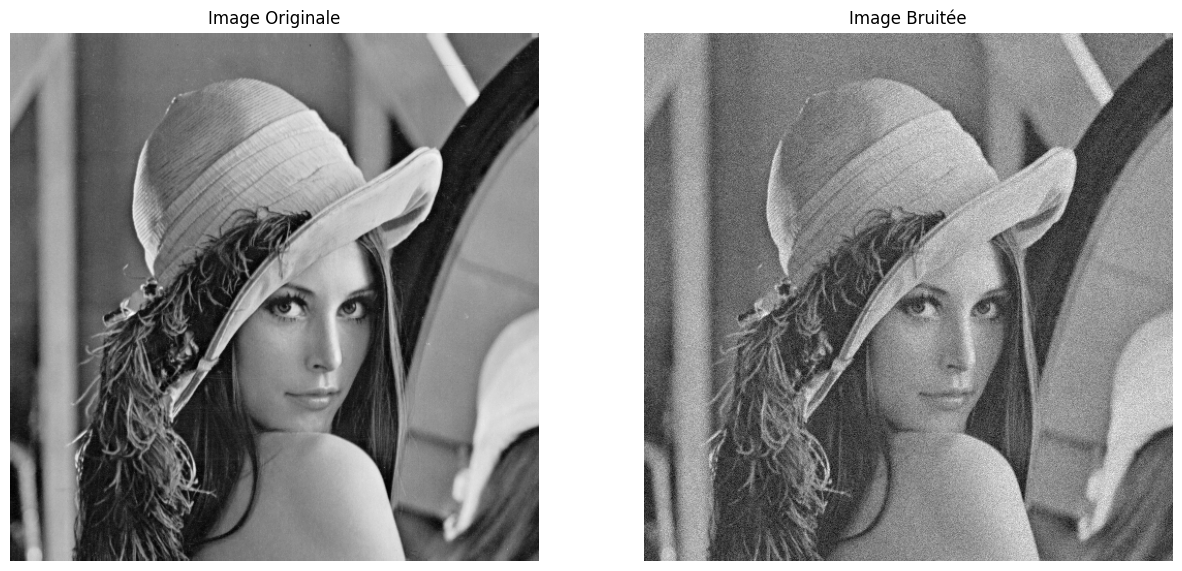

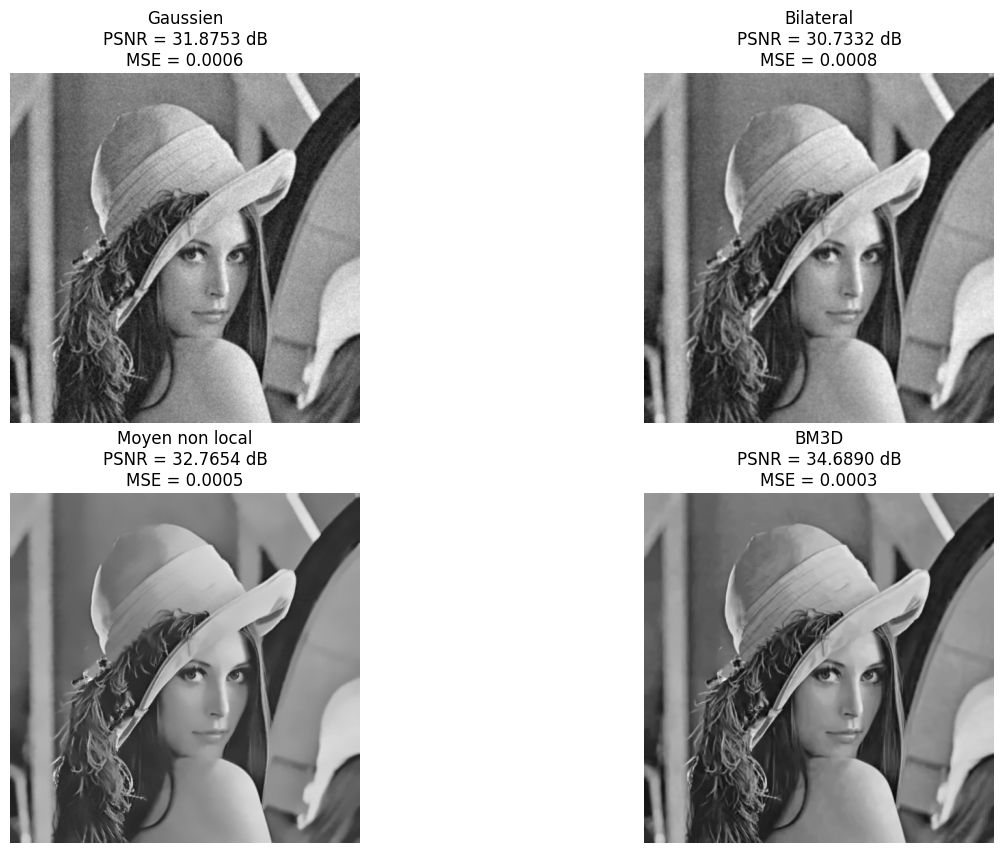

In [9]:

image_gaussien = filtrage_gaussien(image_bruitee, ksize=best_gaussien["ksize"], sigma=best_gaussien["sigma"])
image_bilateral = filtrage_bilateral(image_bruitee, d=best_bilateral["d"], sigma_color=best_bilateral["sigma_color"], sigma_space=best_bilateral["sigma_space"])
image_moyen_non_local = filtrage_moyen_non_local(image_bruitee_8bit, h=best_nlm["h"], template_window_size=best_nlm["template_window_size"], search_window_size=best_nlm["search_window_size"])
image_bm3d = filtrage_bm3d(image_bruitee, sigma=best_bm3d["sigma"])

psnr_gaussien = psnr(image, image_gaussien)
mse_gaussien = mse(image, image_gaussien)

psnr_bilateral = psnr(image, image_bilateral)
mse_bilateral = mse(image, image_bilateral)

psnr_moyen_non_local = psnr(image_8bit/255, image_moyen_non_local/255)
mse_moyen_non_local = mse(image_8bit/255, image_moyen_non_local/255)

psnr_bm3d = psnr(image, image_bm3d)
mse_bm3d = mse(image, image_bm3d)

plt.figure(figsize=(15, 10))

plt.subplot(1, 2, 1)
plt.title("Image Originale")
plt.imshow(image, cmap='gray')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title("Image Bruitée")
plt.imshow(image_bruitee, cmap='gray')
plt.axis('off')

plt.show()

plt.figure(figsize=(15, 10))

plt.subplot(2, 2, 1)
plt.title(f"Gaussien\nPSNR = {psnr_gaussien:.4f} dB\nMSE = {mse_gaussien:.4f}")
plt.imshow(image_gaussien, cmap='gray')
plt.axis('off')

plt.subplot(2, 2, 2)
plt.title(f"Bilateral\nPSNR = {psnr_bilateral:.4f} dB\nMSE = {mse_bilateral:.4f}")
plt.imshow(image_bilateral, cmap='gray')
plt.axis('off')

plt.subplot(2, 2, 3)
plt.title(f"Moyen non local\nPSNR = {psnr_moyen_non_local:.4f} dB\nMSE = {mse_moyen_non_local:.4f}")
plt.imshow(image_moyen_non_local, cmap='gray')
plt.axis('off')

plt.subplot(2, 2, 4)
plt.title(f"BM3D\nPSNR = {psnr_bm3d:.4f} dB\nMSE = {mse_bm3d:.4f}")
plt.imshow(image_bm3d, cmap='gray')
plt.axis('off')

plt.show()

### 3. Commencez par générer une image sparse, que nous nommerons s, et chargez une image standard en niveaux de gris de votre choix, désignée par x (par exemple, Lena). 

c. Débruiter ys et yb en utilisant un seuillage dur.


#### a. Créez les images ys = s + b et yx = x + b où b représente un bruit Gaussien de 20dB.

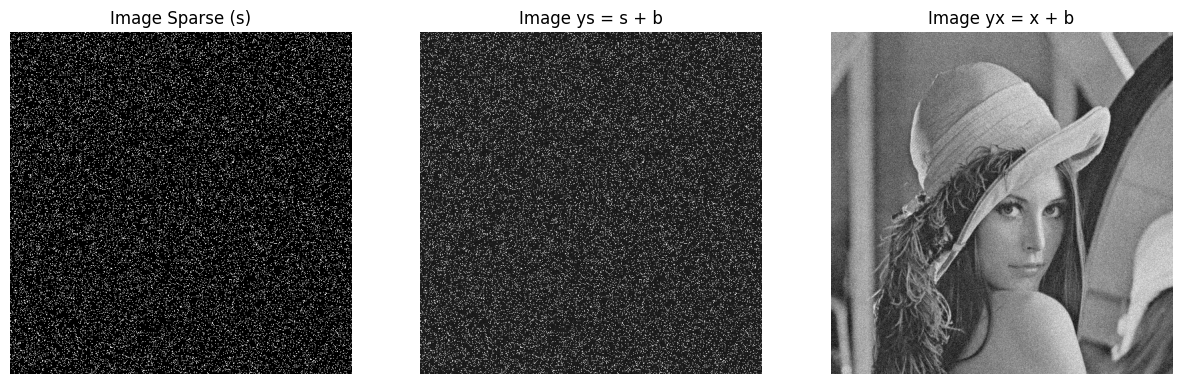

In [10]:
s = np.zeros_like(image)
s[np.random.rand(*s.shape) < 0.1] = 1

SNR = 20

ys = ajouter_bruit_gaussien(s, SNR)
yx = ajouter_bruit_gaussien(image, SNR)

plt.figure(figsize=(15, 10))

plt.subplot(1, 3, 1)
plt.title("Image Sparse (s)")
plt.imshow(s, cmap='gray')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.title("Image ys = s + b")
plt.imshow(ys, cmap='gray')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.title("Image yx = x + b")
plt.imshow(yx, cmap='gray')
plt.axis('off')

plt.show()

#### b. Débruiter ys et yb en utilisant un seuillage doux. Expliquer la démarche. Pour yb on utilisera la décomposition dyadique et son inverse : https://cloud.irit.fr/index.php/s/7W2kXMxo8LpVmOl.

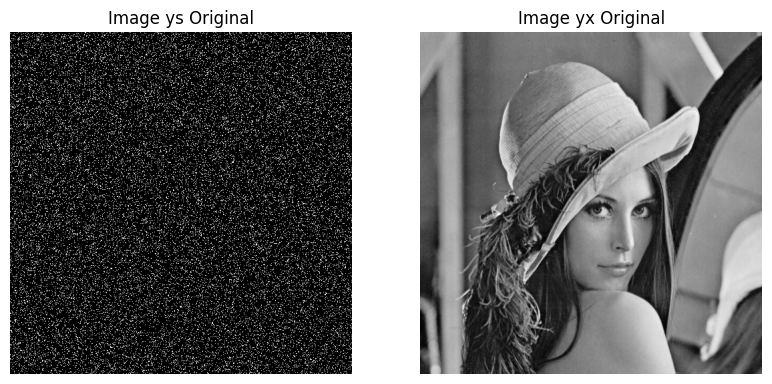

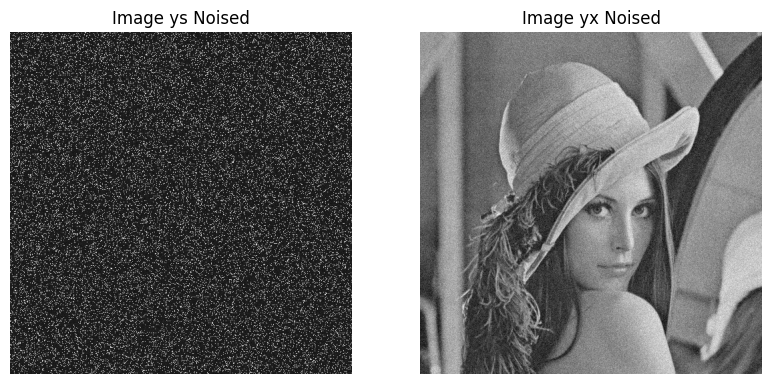

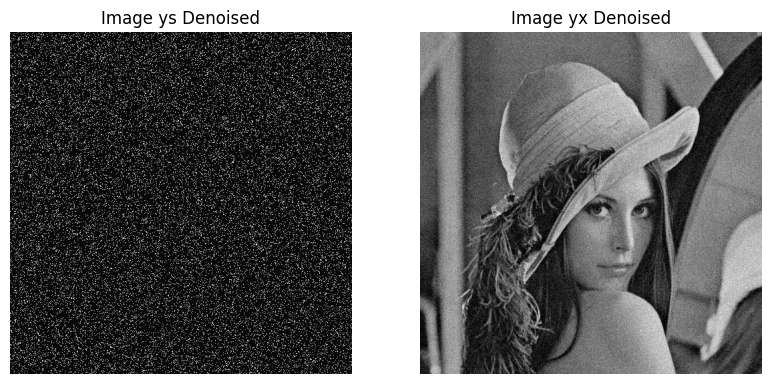

In [13]:
def soft_thresholding(data, threshold):
    return np.sign(data) * np.maximum(np.abs(data) - threshold, 0)

def wavelet(img, ordre):
    s = img.shape
    imw = np.zeros(s, dtype=np.float64)
    imcopie = img.astype(np.float64)
    
    largeur = s[0] // 2
    i = 1
    
    while i <= ordre and largeur >= 1:
        for j in range(largeur):
            for k in range(largeur):
                a = imcopie[j * 2, k * 2]
                b = imcopie[j * 2 + 1, k * 2]
                c = imcopie[j * 2, k * 2 + 1]
                d = imcopie[j * 2 + 1, k * 2 + 1]

                imw[j, k] = (a + b + c + d) / 4
                imw[j + largeur, k] = ((a + b) - (c + d)) / 4
                imw[j, k + largeur] = ((a + c) - (b + d)) / 4
                imw[j + largeur, k + largeur] = ((a - b) - (c - d)) / 4

        i += 1
        largeur //= 2
        imcopie = imw.copy()

    return imw

level = 1
threshold = 0.1

ys_denoised = soft_thresholding(ys, threshold)
yx_denoised = soft_thresholding(yx, threshold)

plt.figure(figsize=(15, 10))

plt.subplot(1, 3, 1)
plt.title("Image ys Original")
plt.imshow(s, cmap='gray')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.title("Image yx Original")
plt.imshow(image, cmap='gray')
plt.axis('off')

plt.figure(figsize=(15, 10))

plt.subplot(1, 3, 1)
plt.title("Image ys Noised")
plt.imshow(ys, cmap='gray')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.title("Image yx Noised")
plt.imshow(yx, cmap='gray')
plt.axis('off')

plt.show()

plt.figure(figsize=(15, 10))

plt.subplot(1, 3, 1)
plt.title("Image ys Denoised")
plt.imshow(ys_denoised, cmap='gray')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.title("Image yx Denoised")
plt.imshow(yx_denoised, cmap='gray')
plt.axis('off')

plt.show()